In [2]:
import torch

In [3]:
import math
import numpy as np
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
from lyft_simulation import *

In [4]:
num_riders = 10
part_size = num_riders // 4

In [197]:
#480, 1080, 1320, total 1440, 0 is placeholder for uniform distribution
request_times_means = torch.tensor([8 * 60, 18 * 60, 22 * 60, 0]) 

In [198]:
request_times_stds = torch.tensor([60, 60, 60, 0])

In [199]:
#torch.rand(num_riders)
#uniform_values_riders = torch.arange(0, 24 * 60)
uniform_values_riders = torch.rand((num_riders, 3)) * 24 * 60

In [230]:
num_components = 3 
uniform_weight = 0.2
daily_max_requests = 5

In [282]:
#lambda for daily num_requests 
lambda_commuter, lambda_party_goer, lambda_sporadic = 1.0, 0.75, 0.75
poisson_lambda_lst = [1.0, 0.75, 0.5]

In [269]:
#need to multiply commuter_percentage*2(morning and evening)
commuter_percentage = 0.25
party_goer_percentage = 0.25
sporadic_rider_percentage = 0.25

In [283]:
lambda_riders = torch.cat([
    torch.full((int(num_riders * commuter_percentage * 2),), lambda_commuter),
    torch.full((int(num_riders * party_goer_percentage),), lambda_party_goer),
    torch.full((int(num_riders * sporadic_rider_percentage),), lambda_sporadic)
])

In [284]:
lambda_riders

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 0.7500, 0.7500, 0.7500, 0.7500,
        0.7500])

In [201]:
gaussian_mask = torch.rand(num_riders) < (1 - uniform_weight)
component_indices = torch.where(
    gaussian_mask,
    torch.randint(0, num_components, (num_riders,)),
    num_components
)

In [209]:
request_times = torch.where(
    component_indices < num_components,
    request_times_means[component_indices] + request_times_stds[component_indices] * torch.randn(num_riders),
    torch.randint(0, 24 * 60, (num_riders,), dtype=torch.float)
).clamp(min=0, max=24*60-1).unsqueeze(1)

In [210]:
### assume each rider will have one request per day
request_times

tensor([[ 570.1089],
        [1210.9481],
        [1127.2522],
        [1439.0000],
        [1027.0530],
        [1100.6929],
        [1138.2754],
        [1404.3544],
        [ 867.0000],
        [1102.0916]])

In [211]:
start_locations = torch.rand(num_riders, 2)
end_locations = torch.rand(num_riders, 2)

In [212]:
request_times.size(), start_locations.size(), end_locations.size()

(torch.Size([10, 1]), torch.Size([10, 2]), torch.Size([10, 2]))

In [213]:
riders = torch.cat((request_times, start_locations, end_locations), 1)

In [214]:
riders

tensor([[5.7011e+02, 7.9924e-01, 3.1234e-01, 1.5783e-01, 6.0394e-01],
        [1.2109e+03, 1.6344e-01, 7.0099e-01, 1.4030e-01, 7.3016e-01],
        [1.1273e+03, 8.5393e-01, 3.9847e-01, 8.9361e-02, 5.0212e-01],
        [1.4390e+03, 3.3003e-01, 3.8417e-01, 3.1413e-02, 4.9430e-01],
        [1.0271e+03, 4.3182e-01, 5.5633e-01, 2.7362e-01, 2.1845e-01],
        [1.1007e+03, 2.4589e-01, 4.5831e-01, 1.9662e-01, 6.5581e-02],
        [1.1383e+03, 5.4955e-01, 1.3266e-01, 1.6018e-01, 9.6618e-01],
        [1.4044e+03, 1.6129e-01, 3.6003e-01, 5.7648e-01, 5.3612e-01],
        [8.6700e+02, 7.2542e-01, 8.7081e-01, 7.1688e-01, 8.8898e-01],
        [1.1021e+03, 6.7640e-01, 2.8853e-01, 2.3303e-01, 3.2791e-01]])

In [ ]:
### every 25% of the num_riders index correspond to a rider type, each rider has a lambda 
### for each day, sample relative lambda and poission for the daily number of request(from 0 to 5)
### then sample the corresponding request time with mask based on rider type

In [289]:
daily_num_requests = torch.poisson(lambda_riders).clamp(max=daily_max_requests)

In [294]:
daily_num_requests

tensor([1., 0., 1., 0., 2., 1., 0., 0., 0., 0.])

In [303]:
request_indices = torch.arange(daily_num_requests.sum().int())

In [304]:
request_indices

tensor([0, 1, 2, 3, 4])

In [308]:
# rider index for each request
rider_indices = torch.repeat_interleave(torch.arange(num_riders), daily_num_requests.int())

In [309]:
rider_indices

tensor([0, 2, 4, 4, 5])

In [291]:
indices = torch.arange(num_riders)
mask1 = indices < part_size
mask2 = (indices >= part_size) & (indices < 2 * part_size)
mask3 = (indices >= 2 * part_size) & (indices < 3 * part_size)
mask4 = indices >= 3 * part_size

In [320]:
mask1[rider_indices]

tensor([ True, False, False, False, False])

In [319]:
mask2[rider_indices]

tensor([False,  True, False, False, False])

In [317]:
mask3[rider_indices]

tensor([False, False,  True,  True,  True])

In [316]:
request_times = torch.where(
    mask1[rider_indices],
    torch.normal(request_times_means[0], request_times_stds[0], size=(len(request_indices),)),
    torch.where(
        mask2[rider_indices],
        torch.normal(request_times_means[1], request_times_stds[1], size=(len(request_indices),)),
        torch.where(
            mask3[rider_indices],
            torch.normal(request_times_means[2], request_times_stds[2], size=(len(request_indices),)),
            torch.randint(0, 24 * 60, size=(len(request_indices),), dtype=torch.float)
        )
    )
).clamp(min=0, max=24*60-1).unsqueeze(1)

In [318]:
request_times

tensor([[ 526.5052],
        [1103.4878],
        [1289.7363],
        [1343.8998],
        [1221.3777]])

In [321]:
start_locations = torch.rand(len(request_indices), 2)
end_locations = torch.rand(len(request_indices), 2)

In [322]:
riders = torch.cat((request_times, start_locations, end_locations), 1)

In [323]:
riders

tensor([[5.2651e+02, 7.8714e-01, 1.9073e-02, 9.4093e-02, 4.9175e-01],
        [1.1035e+03, 7.6533e-01, 8.5661e-01, 3.2850e-01, 6.7690e-01],
        [1.2897e+03, 1.6956e-01, 3.3152e-01, 7.1632e-01, 9.1407e-01],
        [1.3439e+03, 1.3212e-02, 2.2150e-01, 7.7902e-01, 4.1861e-02],
        [1.2214e+03, 4.8751e-01, 6.3432e-02, 2.6996e-01, 7.6713e-01]])

### test py code

In [5]:
T0_pricing_params = (5, 0.78, 1.82)
lr = 0.01
simulation_week1 = WeeklySimulation(lr, T0_pricing_params)

In [4]:
riders_week1 = simulation_week1.simulate_riders()

In [6]:
riders_week1.size()

torch.Size([1249, 5])

In [7]:
riders_week1[0]

tensor([4.3750e+02, 8.2416e-01, 6.8805e-01, 8.5149e-01, 3.9761e-01])

In [8]:
simulation_week1.get_subblock_index(riders_week1[:, 1], riders_week1[:, 2])

tensor([14,  9, 15,  ...,  9,  6,  1], dtype=torch.int32)

In [9]:
simulation_week1.get_subblock_index(riders_week1[:, 3], riders_week1[:, 4])

tensor([13,  9, 10,  ...,  8, 13,  8], dtype=torch.int32)

In [6]:
T0_pricing_params = (5, 0.78, 1.82)
lr = 0.01
simulation_week1 = WeeklySimulation(lr, T0_pricing_params)

In [7]:
rider_week1_lst = []
for i in range(7):
    rider_week1_lst.append(simulation_week1.simulate_riders())

In [8]:
def rider_id_to_type(rider_idx, num_riders=1000, rider_types=4):
    threshold = num_riders // rider_types
    if rider_idx < threshold:
        return 0
    elif threshold <= rider_idx < 2 * threshold:
        return 1
    elif 2 * threshold <= rider_idx < 3 * threshold:
        return 2
    else:
        return 3

In [64]:
rider_type_map = {
    0: 'commuters_morning',
    1: 'commuters_afternoon',
    2: 'party_goers',
    3: 'sporadic'
}

In [65]:
rider_type_map

{0: 'commuters_morning',
 1: 'commuters_afternoon',
 2: 'party_goers',
 3: 'sporadic'}

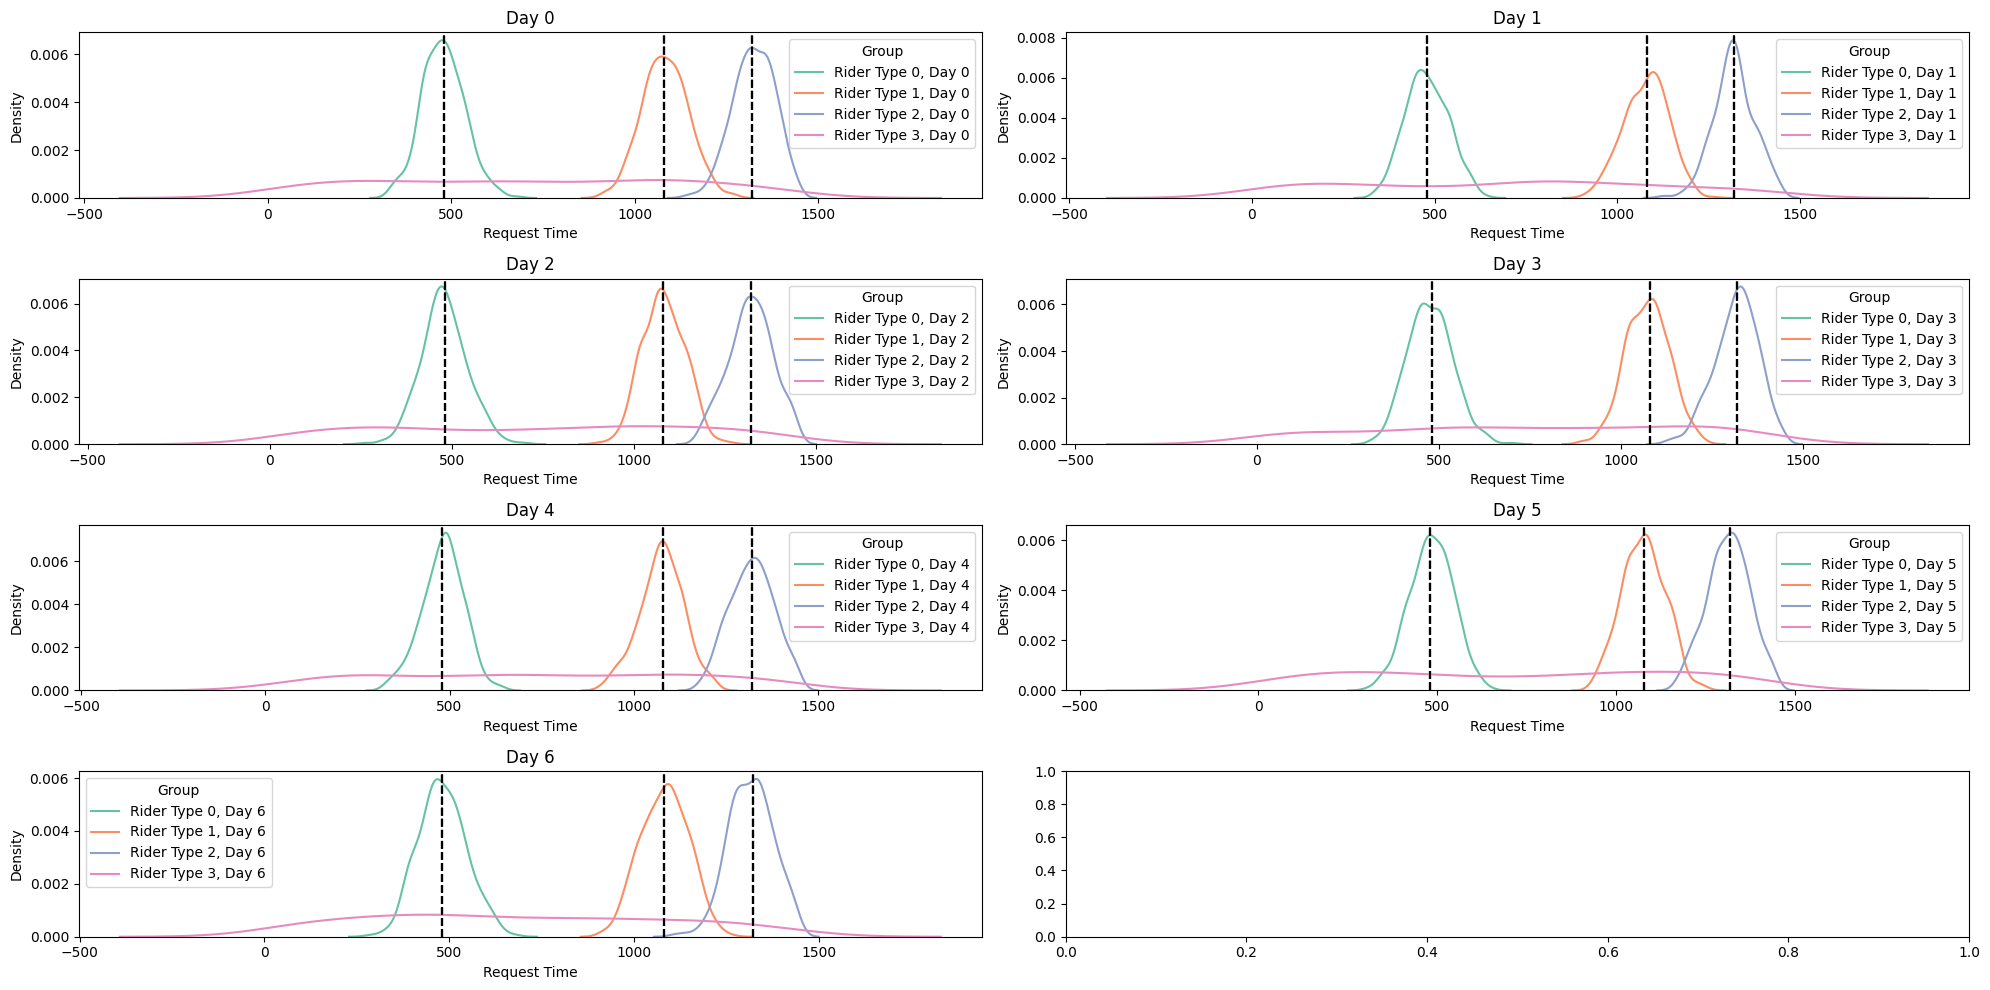

In [9]:
# Define a colormap for rider types
colors = sns.color_palette("Set2", 4)

num_cols = 2

# Calculate the number of rows needed based on the number of DataFrames
num_rows = len(rider_week1_lst) // num_cols + 1  # Ceiling division to ensure all DataFrames are plotted

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 10))

# Plot each DataFrame on its corresponding subplot
for i, (data, ax) in enumerate(zip(rider_week1_lst, axes.flatten())):
    cur_day_requests_df = pd.DataFrame(data, columns=['request_timestamp', 'start_x', 'start_y', 'end_x', 'end_y', 'rider_idx'])
    cur_day_requests_df['day_idx'] = i
    cur_day_requests_df['rider_type'] = cur_day_requests_df['rider_idx'].apply(rider_id_to_type)
    cur_day_requests_df['rider_idx'] = cur_day_requests_df['rider_idx'].astype(int)
    cur_day_requests_df['request_timestamp'] = cur_day_requests_df['request_timestamp'].astype(int)

    # Group by day_idx and rider_type
    grouped = cur_day_requests_df.groupby(['day_idx', 'rider_type'])

    # Plot KDEs for each group
    for name, group in grouped:
        day, rider_type = name
        #, cut=(0, 24*60-1)
        sns.kdeplot(data=group['request_timestamp'], label=f'Rider Type {rider_type}, Day {day}', color=colors[rider_type] 
                    , ax=ax)
        ax.axvline(x=8 * 60, color='black', linestyle='--')
        ax.axvline(x=18 * 60, color='black', linestyle='--')
        ax.axvline(x=22 * 60, color='black', linestyle='--')


    # Customize plot
    ax.set_title(f'Day {i}')
    ax.set_xlabel('Request Time')
    ax.set_ylabel('Density')
    ax.legend(title='Group')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [45]:
daily_requests_by_type_count_df = pd.DataFrame(columns=['request_timestamp'])


# Plot each DataFrame on its corresponding subplot
for i, data in enumerate(rider_week1_lst):
    cur_day_requests_df = pd.DataFrame(data, columns=['request_timestamp', 'start_x', 'start_y', 'end_x', 'end_y', 'rider_idx'])
    cur_day_requests_df['day_idx'] = i
    cur_day_requests_df['rider_type'] = cur_day_requests_df['rider_idx'].apply(rider_id_to_type)
    cur_day_requests_df['rider_idx'] = cur_day_requests_df['rider_idx'].astype(int)
    cur_day_requests_df['request_timestamp'] = cur_day_requests_df['request_timestamp'].astype(int)

    # Group by day_idx and rider_type
    grouped = cur_day_requests_df.groupby(['day_idx', 'rider_type']).count()['request_timestamp']
    #daily_requests_by_type_count_df['day_idx'] = i
    daily_requests_by_type_count_df = pd.concat([daily_requests_by_type_count_df, grouped], axis=0)
    #print(grouped)

In [53]:
daily_requests_by_type_count_df.reset_index(inplace=True)

In [55]:
daily_requests_by_type_count_df[['day_idx', 'rider_type']] = pd.DataFrame(daily_requests_by_type_count_df['index'].tolist()
                                                                , index=daily_requests_by_type_count_df.index)


In [60]:
daily_requests_by_type_count_df = daily_requests_by_type_count_df.rename(columns={'request_timestamp': 'daily_num_requests'})

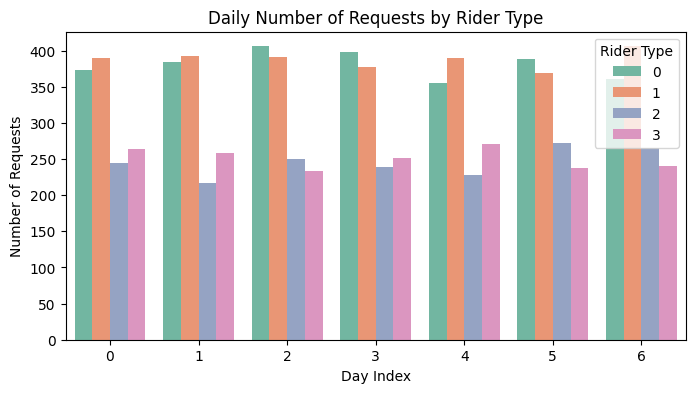

In [63]:
# Initialize the matplotlib figure
plt.figure(figsize=(8, 4))

# Create the bar plot
sns.barplot(x='day_idx', y='daily_num_requests', hue='rider_type', data=daily_requests_by_type_count_df, palette='Set2')

# Add titles and labels
plt.title('Daily Number of Requests by Rider Type')
plt.xlabel('Day Index')
plt.ylabel('Number of Requests')
plt.legend(title='Rider Type')

# Show the plot
plt.show()

In [37]:
# num_riders = 1000
# daily_max_requests = 5
# commuter_percentage, party_goer_percentage, sporadic_rider_percentage = 0.25, 0.25, 0.25
# lambda_commuter, lambda_party_goer, lambda_sporadic = 1.5, 1, 1
# lambda_riders = torch.cat([
#             torch.full((int(num_riders * commuter_percentage * 2),), lambda_commuter),
#             torch.full((int(num_riders * party_goer_percentage),), lambda_party_goer),
#             torch.full((int(num_riders * sporadic_rider_percentage),), lambda_sporadic)
#         ])

In [45]:
# daily_num_requests = torch.poisson(lambda_riders).clamp(max=daily_max_requests)
# request_indices = torch.arange(daily_num_requests.sum().int())

# # rider index for each request
# rider_indices = torch.repeat_interleave(torch.arange(num_riders), daily_num_requests.int())
# indices = torch.arange(num_riders)
# len(rider_indices)